# Road Density Analysis in Tamale, Ghana

This notebook initially focuses on performing road density analysis using OpenStreetMap (OSM) data for Tamale, Ghana. Subsequently, it will incorporate satellite image data to enhance the analysis. This methodology is designed for potential scaling to larger areas.

## Acquiring OpenStreetMap Data for Tamale

We use OpenStreetMap's pbf format database dumps, available at [Planet OpenStreetMap](https://planet.openstreetmap.org/pbf/), for our data source. To isolate data specific to Tamale, we use the [Osmium Tool](https://osmcode.org/osmium-tool/). A defined geographic rectangle covering Tamale has been crafted using [geojson.io](https://geojson.io/#map=10.61/9.4417/-0.8319) and stored in `data/tamale.geojson`. Our analysis will be conducted within this designated area.

The process involves several step:

1. **Creating a Data Extract with Osmium**: Using Osmium's capabilities ([documentation](https://osmcode.org/osmium-tool/manual.html#creating-geographic-extracts)), we generate a specific extract for Tamale:
    ```
    osmium extract -p tamale.geojson planet-[date].osm.pbf -o tamale-[date].osm.pbf
    ```
1. **Filtering Road Data**: Next, we refine the dataset to include only road information ([documentation](https://osmcode.org/osmium-tool/manual.html#filtering-by-tags)):
    ```
    osmium tags-filter tamale-[date].osm.pbf w/highway -o tamale-[date]-roads.osm.pbf
    ```
1. **Exporting to GeoJSON**: The final step involves converting the pbf file into a GeoJSON format, making it compatible with the geopandas library in Python:
    ```
    osmium export tamale-[date]-roads.osm.pbf -o tamale-[date]-roads.geojson
    ```

With these steps completed, we're set to proceed with the road density analysis using Python.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
tamale_roads_2023 = gpd.read_file('data/tamale-231113-roads.geojson')
tamale_roads_2020 = gpd.read_file('data/tamale-200831-roads.geojson')
tamale_roads_2023.geometry.head()

0    POINT (-0.84197 9.42584)
1    POINT (-0.84772 9.39535)
2    POINT (-0.84765 9.39528)
3    POINT (-0.84821 9.39530)
4    POINT (-0.84823 9.39480)
Name: geometry, dtype: geometry

In [3]:
tamale_roads_2020.geometry.head()

0    POINT (-0.84197 9.42584)
1    POINT (-0.84233 9.40590)
2    POINT (-0.84246 9.40587)
3    POINT (-0.84772 9.39535)
4    POINT (-0.84765 9.39528)
Name: geometry, dtype: geometry

In [4]:
# As we can see, the data still contains points. We are only interested in the roads, so we will filter the data to only contain lines.
tamale_roads_2023 = tamale_roads_2023[tamale_roads_2023.geometry.type == 'LineString']
tamale_roads_2020 = tamale_roads_2020[tamale_roads_2020.geometry.type == 'LineString']
tamale_roads_2023.geometry.head()

114    LINESTRING (-0.84708 9.43068, -0.84615 9.43071...
115    LINESTRING (-0.84694 9.43361, -0.84684 9.43349...
116    LINESTRING (-0.83902 9.43728, -0.83902 9.43679...
117    LINESTRING (-0.84312 9.43426, -0.84225 9.43429...
118    LINESTRING (-0.84664 9.47548, -0.84662 9.47631...
Name: geometry, dtype: geometry

In [5]:
tamale_roads_2020.geometry.head()

75    LINESTRING (-0.84708 9.43068, -0.84615 9.43071...
76    LINESTRING (-0.84694 9.43361, -0.84684 9.43349...
77    LINESTRING (-0.83902 9.43728, -0.83902 9.43679...
78    LINESTRING (-0.84312 9.43426, -0.84225 9.43429...
79    LINESTRING (-0.84664 9.47548, -0.84660 9.47637...
Name: geometry, dtype: geometry

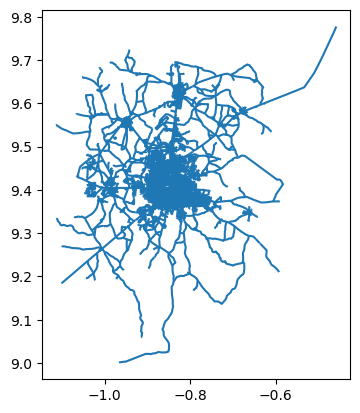

In [6]:
# We can now plot the roads
tamale_roads_2023.plot()
plt.show()

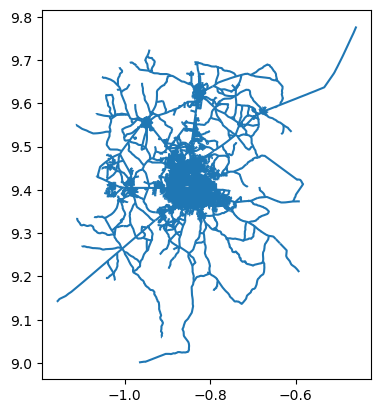

In [7]:
tamale_roads_2020.plot()
plt.show()

In [8]:
# We reproject the data to the World Mercator projection (EPSG:3395) to be able to calculate distances in meters
tamale_roads_2023 = tamale_roads_2023.to_crs(epsg=3395)
tamale_roads_2020 = tamale_roads_2020.to_crs(epsg=3395)

In [9]:
# We compute the total length of the roads
total_length_2023 = 0
total_length_2020 = 0

for line in tamale_roads_2023.geometry:
    total_length_2023 += line.length

for line in tamale_roads_2020.geometry:
    total_length_2020 += line.length

print(f"Total length of all roads in 2023: {total_length_2023 / 1000:.2f}km")
print(f"Total length of all roads in 2018: {total_length_2020 / 1000:.2f}km")

Total length of all roads in 2023: 4409.10km
Total length of all roads in 2018: 4105.97km


In [10]:
# We compute the expansion of the road network between 2020 and 2023
expansion = (total_length_2023 - total_length_2020) / total_length_2020 * 100
print(f"Expansion of the road network: {expansion:.2f}%")

Expansion of the road network: 7.38%


# Acquiring landsat data for Tamale
Data can be downloaded at from https://earthexplorer.usgs.gov, selecting the area of interest; in the search criteria can be also useful to set 'cloud cover' to the minimum.
Then we select the following datasets: Landsat >> Landsat Collection 2 Level-2 >> Landsat 8-9 OLI/TIRS C2 L2, then we download all the files in Level-2 Surface Reflectance Bands.
These files have to be saved in a repository named 'tamale_landsat' and the TIF file for the i-th bandwidth  has to be named SR_B{i}.TIF (e.g. SR_B1.TIF)

These files contain files .TIF regarding the reflectance of the surface for 7 different bandwidth, detailed informations are found in https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2.

At the end of the data processing we obtain a 3D tensor called 'data_fin' containing the values of pixels for the 7 bandwidth, and a one-hot matrix called 'osm_mask' showing in which pixels there are roads

In [11]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import geometry_mask
import numpy as np

In [12]:
file_path = "tamale_landsat/SR_B1.tif"
dataset = rasterio.open(file_path)
data = dataset.read(1)

In [13]:
# Here we project the files in the ESPC:3395, the same of OSM data

def projecting(input_file, output_file):
    dst_crs = 'EPSG:3395'

    # Open the input dataset
    with rasterio.open(input_file) as src:
        # Get the transformation parameters and dimensions for the output file
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
    
        # Create the output dataset
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_file, 'w', **kwargs) as dst:
            # Perform the reprojection
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

In [14]:
for i in range(1,8):
    input_file = f'tamale_landsat/SR_B{i}.TIF'
    output_file = f'tamale_landsat/SR_B{i}_reprojected.TIF'
    projecting(input_file, output_file)

In [15]:
# We collect all the infos in a 3D tensor

dataset_proj = rasterio.open('tamale_landsat/SR_B1_reprojected.TIF')
data_proj = dataset_proj.read(1)
data_fin = np.copy(data_proj)
data_fin = data_fin[:,:,np.newaxis]
for i in range(2,8):
    file_path = f"tamale_landsat/SR_B{i}_reprojected.TIF"
    with rasterio.open(file_path) as src:
        data_ = src.read(1)
        data_ = data_[:,:,np.newaxis]
        data_fin = np.append(data_fin, data_, axis=-1)
print(data_fin.shape)

(7765, 7608, 7)


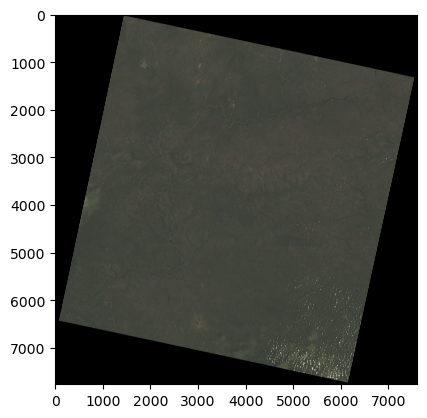

In [16]:
# For visual purposes we plot the image reconstructed from landsat data
with rasterio.open("tamale_landsat/SR_B4_reprojected.TIF") as src_red, \
     rasterio.open("tamale_landsat/SR_B3_reprojected.TIF") as src_green, \
     rasterio.open("tamale_landsat/SR_B2_reprojected.TIF") as src_blue:

    red_band = src_red.read(1)
    green_band = src_green.read(1)
    blue_band = src_blue.read(1)

    # Normalize to [0, 1]
    red_band = red_band / np.max(red_band)
    green_band = green_band / np.max(green_band)
    blue_band = blue_band / np.max(blue_band)

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    plt.imshow(rgb_image)
    plt.show()

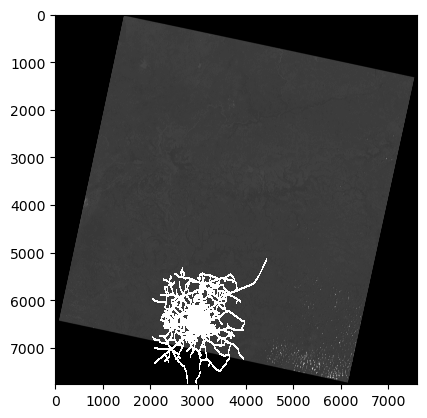

In [17]:
# We calcuate the mask (pixels where there roads are), and plot the new graph with removed pixels

# Open Landsat data
with rasterio.open("tamale_landsat/SR_B1_reprojected.TIF") as src:
    dataset_proj = src.read(1)
    transform = src.transform

# Rasterize OSM road data
osm_mask = geometry_mask(tamale_roads_2023.geometry, out_shape=dataset_proj.shape, transform=transform, invert=True)

# Apply the OSM road mask to Landsat data
roads_masked = np.ma.masked_array(dataset_proj, mask=osm_mask)

plt.imshow(roads_masked, cmap='gray')
plt.show()                                         
                                             

In [19]:
# Some pixels in the 'black area' are indicated as street,
# however Landsat data don't have any information about these pixels
# so we don't want them to be indicated as if there is a road

osm_mask[np.sum(data_fin,axis=-1)==0]=0

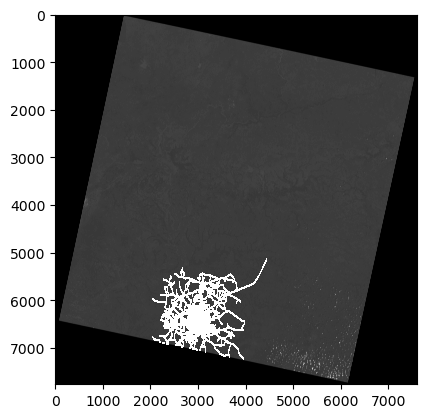

In [20]:
# Finally we plot the final result
roads_masked_ = np.ma.masked_array(dataset_proj, mask=osm_mask)

# Optionally, visualize the result
plt.imshow(roads_masked_, cmap='gray')
plt.show()  